# EMNIST Lab

## Imports and stuff

In [33]:
!apt update && apt install gcc unzip rsync -y

In [37]:
!pip install -q matplotlib seaborn wandb timm ray[tune] torchvision hiredis GPy sklearn gdown madgrad tensorboard pytorch-lightning

In [7]:
!gdown "https://drive.google.com/uc?id=1Id4fM7EI4GPN8gAMT3AWR0Yx8GARUgW9"

Downloading...
From: https://drive.google.com/uc?id=1Id4fM7EI4GPN8gAMT3AWR0Yx8GARUgW9
To: /workspace/images.zip
100%|██████████████████████████████████████| 68.4M/68.4M [00:00<00:00, 69.9MB/s]


In [2]:
!unzip "images.zip" -d "data"

In [9]:
%matplotlib inline

In [37]:
import os
from functools import partial

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import random_split
from torch.utils.tensorboard import SummaryWriter

import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger, WandbLogger
import timm

import torchvision
from torchvision import datasets, models
import torchvision.transforms as transforms

from ray import tune
from ray.tune import CLIReporter, JupyterNotebookReporter
from ray.tune.schedulers.pb2 import PB2

from madgrad import MADGRAD

from tqdm.notebook import tqdm
import wandb

In [7]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:99% !important; }</style>"))

In [6]:
!nvidia-smi

Tue Nov 23 18:12:55 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 465.19.01    CUDA Version: 11.3     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:03:00.0 Off |                  N/A |
|  0%   42C    P8    16W / 150W |      1MiB /  8119MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  On   | 00000000:04:00.0 Off |                  N/A |
|  0%   

## Utilities

In [2]:
# function for loading data

def load_data(data_dir="./data"):
    train_transform = transforms.Compose([
        transforms.Grayscale(),  # they are anyway monochrome
        transforms.ToTensor(),
        transforms.RandomRotation(10),  # resize augmentation (10 degrees) [only on train]
        transforms.Resize(28),
        transforms.Normalize((0.5, ), (0.5, ))
    ])
    
    test_transform = transforms.Compose([
        transforms.Grayscale(),
        transforms.ToTensor(),
        transforms.Normalize((0.5, ), (0.5, ))
    ])
    
    train_data = datasets.ImageFolder(root=f"{data_dir}/train", transform=train_transform)
    test_data = datasets.ImageFolder(root=f"{data_dir}/test", transform=test_transform)

    return train_data, test_data

In [76]:
# function for testing accuracy
# it doesn't take test data itself as its argument cause I initially intended to use it only with the PB2 hyperparameter search
# and that way loading data becomes a bit more complex task
# thus, I decided to keep it as is and just adapt other functions to it :)

def test_accuracy(net, device="cpu"):
    train_set, test_set = load_data()

    test_loader = torch.utils.data.DataLoader(
        test_set, batch_size=4, shuffle=False
    )

    correct = 0
    total = 0
    
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return correct / total

In [4]:
# train-val loop *specifically* for use with ray tune hyperparameter search
# splitiing train to train/test as 80/20
# using SGD cause I experimentally found that it works quite well here
# but I'll give MADGRAD one more chance later!

def train_model(config: dict, checkpoint_dir=None, data_dir=None, epochs=10):
    model = config.pop("model")
    lr = config.pop("lr")
    batch_size = config.pop("batch_size")
    net = model(**config)

    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        if torch.cuda.device_count() > 1:
            net = nn.DataParallel(net)
    net.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr, momentum=0.9)
    # optimizer = optim.Adam(net.parameters(), lr=lr)
    # optimizer = optim.AdamW(net.parameters(), lr=lr)
    # optimizer = MADGRAD(net.parameters(), lr=lr)

    if checkpoint_dir:
        model_state, optimizer_state = torch.load(
            os.path.join(checkpoint_dir, "checkpoint"))
        net.load_state_dict(model_state)
        optimizer.load_state_dict(optimizer_state)

    trainset, testset = load_data(data_dir)

    test_abs = int(len(trainset) * 0.8)
    train_subset, val_subset = random_split(
        trainset, [test_abs, len(trainset) - test_abs])

    # setting dataloaders
    
    trainloader = torch.utils.data.DataLoader(
        train_subset,
        batch_size=int(batch_size),
        shuffle=True)
    
    valloader = torch.utils.data.DataLoader(
        val_subset,
        batch_size=int(batch_size),
        shuffle=True)
    
    # training
    for epoch in range(epochs):
        running_loss = 0.0
        epoch_steps = 0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            epoch_steps += 1
            
            if i % 2000 == 1999:  # training loss
                print("[%d, %5d] loss: %.3f" % (epoch + 1, i + 1,
                                                running_loss / epoch_steps))
                running_loss = 0.0

        # validation loss
        val_loss = 0.0
        val_steps = 0
        total = 0
        correct = 0
        
        for i, data in enumerate(valloader, 0):
            with torch.no_grad():
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = net(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                loss = criterion(outputs, labels)
                val_loss += loss.cpu().numpy()
                val_steps += 1
        
        # saving checkpoint via ray
        # because the `train` function uses genetic algorithm which is based on reinforcement learning
        # it select the most performant models, periodically conducts various perturbations
        # changing specific model hyperparams (such as lr) and transferring best model weights to other weak models,
        # what allows to dynamically select the best models
        # just a brilliant algorithm6 but requires lots of compute power and isn't really useful for our data
        # but I had an opportunity and compute power to try it so i decided to do it
        
        with tune.checkpoint_dir(epoch) as checkpoint_dir:
            path = os.path.join(checkpoint_dir, "checkpoint")
            torch.save((net.state_dict(), optimizer.state_dict()), path)

        tune.report(loss=(val_loss / val_steps), accuracy=(correct / total))
        
    print("Finished Training")

In [5]:
# fixing some docker-related stuff

import os
os.environ["RAY_OBJECT_STORE_ALLOW_SLOW_STORAGE"] = "1"

In [6]:
# function for automatic hyperparameter tuning and model training using Ray Tune and Population Based Bandits (PB2) algorithm
# yeah I messed up a bit with my function naming, but it's already kinda late to fix this
# so I hope it won't be really confusing

def train(config, hyperparam_bounds, model_params, num_samples=10, gpus_per_trial=0.5, perturbation_interval=5):
    data_dir = os.path.abspath("./data")
    load_data(data_dir)

    scheduler = PB2(
        time_attr='training_iteration',
        metric="accuracy",
        mode="max",
        perturbation_interval=perturbation_interval,
        hyperparam_bounds=hyperparam_bounds
    )
    
    reporter = JupyterNotebookReporter(
        parameter_columns=list(config.keys()),
        metric_columns=["loss", "accuracy", "training_iteration"],
        overwrite=True,
        metric="accuracy",
        max_progress_rows=40,
        max_report_frequency=3,
        sort_by_metric=True
    )
    
    result = tune.run(
        partial(train_model, data_dir=data_dir),
        name="product_model",
        resources_per_trial={"cpu": 2, "gpu": gpus_per_trial},
        config=config,
        num_samples=num_samples,
        scheduler=scheduler,
        progress_reporter=reporter,
        reuse_actors=True,
        keep_checkpoints_num=5,
        checkpoint_score_attr="accuracy",
        stop=tune.stopper.ExperimentPlateauStopper(metric="accuracy", top=3, patience=5, mode="max"),
        verbose=False
    )

    best_trial = result.get_best_trial("accuracy", "max", "all")
    best_model_checkpoint = result.get_best_checkpoint(best_trial, metric="accuracy", mode="max")
    
    print("Best trial config: {}".format(best_trial.config))
    print("Best trial final validation loss: {}".format(
        best_trial.last_result["loss"]))
    print("Best trial final validation accuracy: {}".format(
        best_trial.last_result["accuracy"]))
    
    model_state, optimizer_state = torch.load(os.path.join(
        best_model_checkpoint, "checkpoint"))
    
    model = config["model"]
    best_trained_model = model(**{param: best_trial.config[param] for param in model_params})
    best_trained_model.load_state_dict(model_state)
    
    device = "cpu"
    
    if torch.cuda.is_available():
        device = "cuda:0"
        if gpus_per_trial > 1:
            best_trained_model = nn.DataParallel(best_trained_model)
            
    best_trained_model.to(device)

    test_acc = test_accuracy(best_trained_model, device)
    print("Best trial test set accuracy: {}".format(test_acc))
    
    return best_trained_model

In [74]:
# function for manual model training
# it also implements usage of the sota MADGRAD optimizer and LabelSmoothing
# it doesn't use validation set and checks everything directly on the test set
# it logs train loss and train/test accuracy to Tensorboard and can be accessed later
# I use cosine annealing with warm restarts (delta = 2 epochs) for lr scheduling

def train_emnist(model, loss, optimizer_name="madgrad", model_name="", num_epochs=10, batch_size=128, lr=1e-3):
    writer = SummaryWriter()
    
    data_dir = os.path.abspath("./data")
    train_set, _ = load_data(data_dir)
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
    
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        if torch.cuda.device_count() > 1:
            model = nn.DataParallel(model)
    model.to(device)
    
    optimizers = {
        "sgd": optim.SGD(model.parameters(), lr=lr, momentum=0.9),
        "adam": optim.Adam(model.parameters(), lr=lr),
        "adamw": optim.AdamW(model.parameters(), lr=lr),
        "madgrad": MADGRAD(model.parameters(), lr=lr)  # source: https://arxiv.org/abs/2101.11075
    }
    
    optimizer = optimizers.get(optimizer_name, optimizers["adamw"])
    
    loss_history = []
    train_history = []
    test_history = []
    
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=2)
    
    for epoch in tqdm(range(num_epochs)):
        model.train()
        loss_sum = 0
        correct_samples = 0
        total_samples = 0
        
        for batch_num, (data, labels) in enumerate(tqdm(train_loader, total=len(train_loader))):
            data = data.float()
                
            data = data.to(device)
            labels = labels.to(device)
            
            preds = model(data)
            loss_value = loss(preds, labels)
            
            _, idx = torch.max(preds, 1)
            correct_samples += torch.sum(idx == labels)
            total_samples += labels.shape[0]
            loss_sum += loss_value
            
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()

        avg_loss = float(loss_sum / (batch_num + 1))
        train_acc = float(correct_samples) / total_samples
        test_acc = test_accuracy(model, device)
        
        writer.add_scalar('Train loss', avg_loss, epoch)
        writer.add_scalar('Train accuracy', train_acc, epoch)
        writer.add_scalar('Test accuracy', test_acc, epoch)
            
        loss_history.append(avg_loss)
        train_history.append(train_acc)
        test_history.append(test_acc)
        
        # checkpointing best model based on test accuracy
        if max(test_history) == test_acc:
            torch.save(model, f"models/{model_name}.pt")
            
        scheduler.step()

        print(f'Epoch {epoch}, Average loss: {avg_loss:.3f}, Train accuracy: {train_acc:.3f}, '
              f'Test accuracy: {test_acc:.3f}')
        
        writer.flush()
     
    return loss_history, train_history, test_history, model

## Model Training

### [2x MLP] Automatic Hyperparameter optimization

In [200]:
class FC2(nn.Module):
    def __init__(
        self, 
        l1=512,
        l2=256,
        activation_fn=nn.ReLU(),
        dropout_prob=0.2
    ):
        
        super(FC2, self).__init__()
        
        self.fc1 = nn.Linear(28 * 28, l1)
        self.fc2 = nn.Linear(l1, l2)
        self.output = nn.Linear(l2, 26)
        
        self.activation_fn = activation_fn
        self.dropout = nn.Dropout(p=dropout_prob)
        
    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.dropout(self.activation_fn(self.fc1(x)))
        x = self.dropout(self.activation_fn(self.fc2(x)))
        x = self.output(x)
        return x

In [13]:
config_fc2 = {
    "model": FC2,
    "l1": tune.choice([256, 512]),
    "l2": tune.choice([128, 256]),
    "activation_fn": tune.choice([nn.ReLU(), nn.Mish(), nn.GELU()]),
    "dropout_prob": tune.loguniform(0.1, 0.2),
    "lr": tune.uniform(5e-3, 1e-1),
    "batch_size": tune.sample_from(lambda _: 2 ** np.random.randint(7, 9))
}

hyperparam_bounds_fc2 = {
    "dropout_prob": [0.1, 0.2],
    "lr": [1e-4, 1e-1],
}

model_fc2 = train(
    config=config_fc2,
    hyperparam_bounds=hyperparam_bounds_fc2,
    model_params=["l1", "l2", "activation_fn", "dropout_prob"],
    num_samples=6,
    gpus_per_trial=1,
    perturbation_interval=3
)

torch.save(model_fc2.state_dict(), "moels/fc3.pt")

Trial name,status,loc,model,l1,l2,activation_fn,dropout_prob,lr,batch_size,loss,accuracy,training_iteration
DEFAULT_1e9f8_00000,TERMINATED,172.17.0.2:2640,<class '__main__.FC2'>,512,256,ReLU(),0.110217,0.0486804,256,0.376349,0.879154,13
DEFAULT_1e9f8_00001,TERMINATED,172.17.0.2:2653,<class '__main__.FC2'>,512,256,Mish(),0.16668,0.0435499,256,0.371673,0.880462,10
DEFAULT_1e9f8_00002,TERMINATED,172.17.0.2:2658,<class '__main__.FC2'>,512,256,ReLU(),0.110217,0.0486804,256,0.357306,0.887846,16
DEFAULT_1e9f8_00003,TERMINATED,172.17.0.2:2619,<class '__main__.FC2'>,512,256,ReLU(),0.110217,0.0486804,256,0.374417,0.881615,13
DEFAULT_1e9f8_00004,TERMINATED,172.17.0.2:2638,<class '__main__.FC2'>,512,256,ReLU(),0.1,0.0001,256,0.28552,0.909154,25
DEFAULT_1e9f8_00005,TERMINATED,172.17.0.2:2628,<class '__main__.FC2'>,512,256,ReLU(),0.110217,0.0486804,256,0.409907,0.874615,10


2021-11-23 18:42:09,311	INFO tune.py:630 -- Total run time: 1694.45 seconds (1694.15 seconds for the tuning loop).


Best trial config: {'model': <class '__main__.FC2'>, 'l1': 512, 'l2': 256, 'activation_fn': ReLU(), 'dropout_prob': 0.1, 'lr': 1e-04, 'batch_size': 256}
Best trial final validation loss: 0.28551969253549386
Best trial final validation accuracy: 0.9091538461538462
Best trial test set accuracy: 0.9034615384615384


**Conclusion**: well, analysis is required in this task, but here we have a bunch of really sophisticated algorithms, based on reinforcment learning, which sample the hyperparameters themselves, choose what to do with the variable learning rate themselves, killing underperforming models and transferring best weights to them also themselves!

The main thing I can say is that setup 512 – 256 – ReLU – ~0.1 – 0.49 is simply the best. You know, it allowed us to achieve 0.9 accuracy on our test set without any overfitting on validation data.

### [3x MLP] Automatic Hyperparameter optimization

In [171]:
class FC3(nn.Module):
    def __init__(
        self, 
        l1=512,
        l2=256,
        l3=128,
        activation_fn=nn.ReLU(),
        dropout_prob=0.2
    ):
        
        super(FC3, self).__init__()
        
        self.fc1 = nn.Linear(28 * 28, l1)
        self.fc2 = nn.Linear(l1, l2)
        self.fc3 = nn.Linear(l2, l3)
        self.output = nn.Linear(l3, 26)
        
        self.activation_fn = activation_fn
        self.dropout = nn.Dropout(p=dropout_prob)
        
    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.dropout(self.activation_fn(self.fc1(x)))
        x = self.dropout(self.activation_fn(self.fc2(x)))
        x = self.dropout(self.activation_fn(self.fc3(x)))
        x = self.output(x)
        return x

In [18]:
config_fc3 = {
    "model": FC3,
    "l1": 512,
    "l2": 256,
    "l3": 128,
    "activation_fn": tune.choice([nn.GELU(), nn.Mish(), nn.ReLU()]),
    "dropout_prob": 0.1,
    "lr": tune.uniform(5e-3, 1e-1),
    "batch_size": tune.sample_from(lambda _: 2 ** np.random.randint(7, 9))
}

hyperparam_bounds_fc3 = {
    "lr": [1e-4, 1e-1],
}

model_fc3 = train(
    config=config_fc3,
    hyperparam_bounds=hyperparam_bounds_fc3,
    model_params=["l1", "l2", "activation_fn", "dropout_prob"],
    num_samples=4,
    gpus_per_trial=0.25,
    perturbation_interval=3
)

torch.save(model_fc3.state_dict(), "models/fc3.pt")

Trial name,status,loc,model,l1,l2,l3,activation_fn,dropout_prob,lr,batch_size,loss,accuracy,training_iteration
DEFAULT_86509_00000,TERMINATED,172.17.0.2:1148,<class '__main__.FC3'>,512,256,128,ReLU(),0.1,0.0324645,256,0.415708,0.868923,10
DEFAULT_86509_00001,TERMINATED,172.17.0.2:1284,<class '__main__.FC3'>,512,256,128,ReLU(),0.1,0.0268478,256,0.41635,0.866923,10
DEFAULT_86509_00002,TERMINATED,172.17.0.2:1283,<class '__main__.FC3'>,512,256,128,ReLU(),0.1,0.0001,256,0.366958,0.884846,16
DEFAULT_86509_00003,TERMINATED,172.17.0.2:1335,<class '__main__.FC3'>,512,256,128,Mish(),0.1,0.0115899,128,0.388701,0.871769,10


2021-11-28 22:36:57,239	INFO tune.py:630 -- Total run time: 931.72 seconds (931.58 seconds for the tuning loop).


Best trial config: {'model': <class '__main__.FC3'>, 'l1': 512, 'l2': 256, 'l3': 128, 'activation_fn': ReLU(), 'dropout_prob': 0.1, 'lr': 1e-04, 'batch_size': 256}
Best trial final validation loss: 0.3669576349796033
Best trial final validation accuracy: 0.8848461538461538
Best trial test set accuracy: 0.8943076923076924


**Conclusion**: My thoughts about this model are the same comparing to the previous model.

The best one is 512 – 256 – 128 – ReLU – 0.1 – 0.0001, achieving about the same accuracy as the 2-layer model

### Performance Analysis

In [202]:
_, test_data = load_data()

In [239]:
model_fc2 = FC2()

fc2_weights = torch.load("models/fc2.pt")
model_fc2.load_state_dict(fc2_weights)
model_fc2.cpu()

FC2(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (output): Linear(in_features=256, out_features=26, bias=True)
  (activation_fn): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
)

In [245]:
test_predictions = []
test_labels = []

for data, labels in tqdm(test_data, total=len(test_data)):
    outputs = model_fc2(data)
    _, preds = torch.max(outputs.data, 1)
    test_labels.append(labels)
    test_predictions.append(preds.item())

  0%|          | 0/13000 [00:00<?, ?it/s]

In [247]:
print("Labels:", test_labels[:5])
print("Predictions:", test_predictions[:5])

Labels: [0, 0, 0, 0, 0]
Predictions: [0, 0, 0, 0, 0]


In [259]:
test_cf = confusion_matrix(test_labels, test_predictions)
test_cf = pd.DataFrame(test_cf, index=test_data.classes, columns=test_data.classes)

<AxesSubplot:>

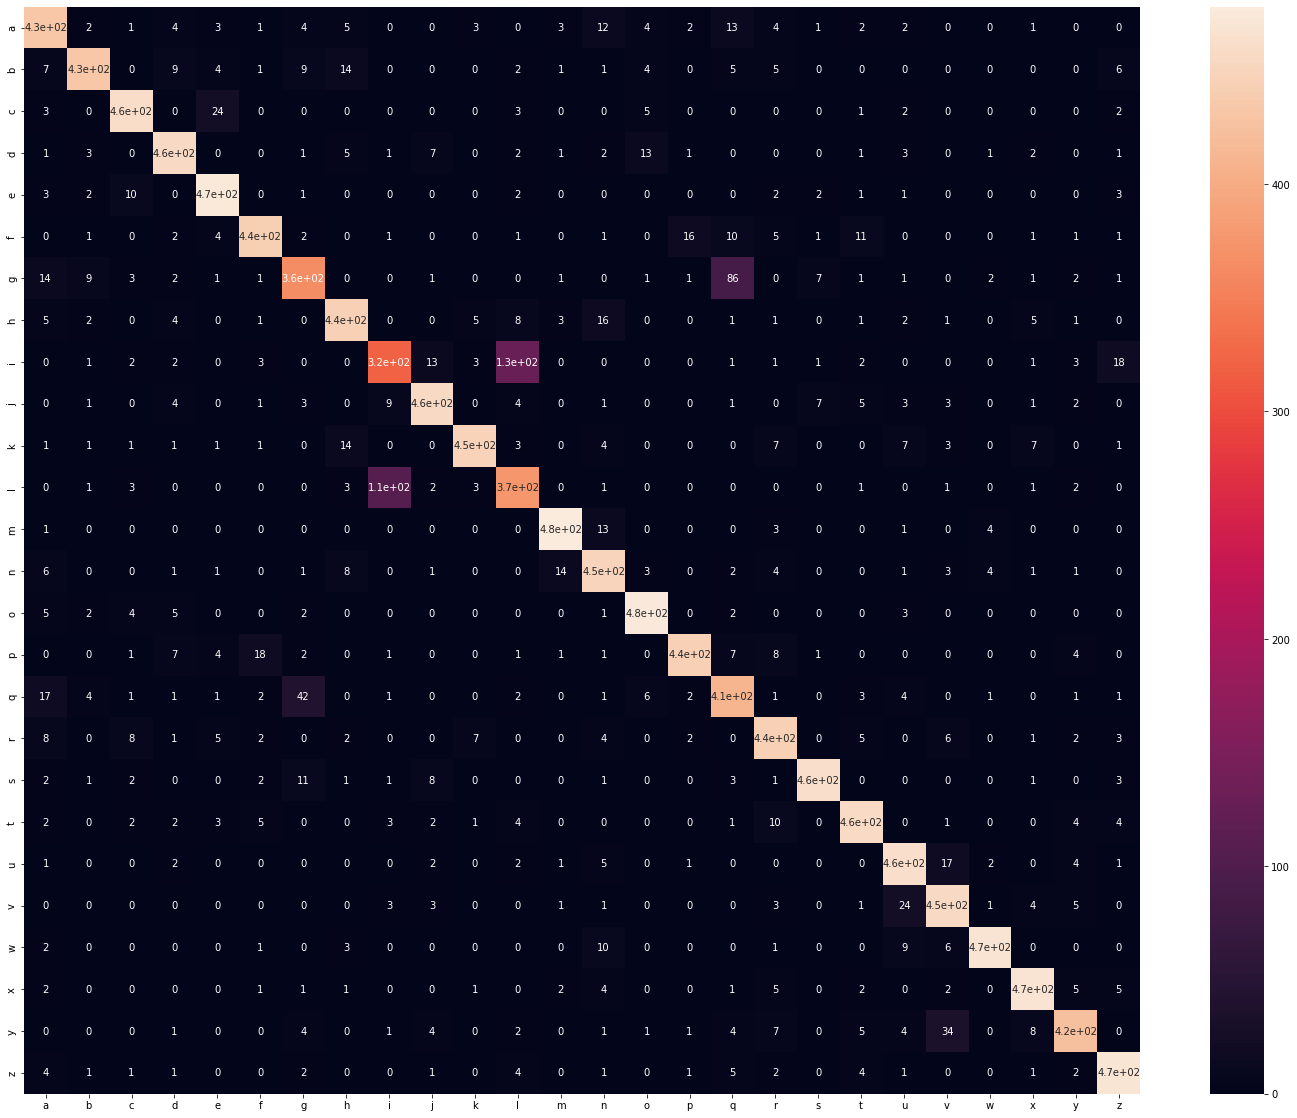

In [264]:
plt.figure(figsize=(25, 20))
sns.heatmap(test_cf, annot=True) 

- There are 2 confusing letterpairs (they look really similar): 
    - `l <-> i`
    - `g <-> q`
- Sometimes the aforementioned pairs are being confused:
    - `a <-> q`
    - `y <-> v`
- For some reason this letter get confused with each other:
    - `i <-> z`
    
**Nethertheless, this model is quite good (and the models below are even better).**

### Model mistakes visualization

In [374]:
# image viz
def visualize_images(indices, data, title='', max_num=10):
    to_show = min(len(indices), max_num)
    fig = plt.figure(figsize=(10, 1.5))
    fig.suptitle(title)
    for i, index in enumerate(indices[:to_show]):
        plt.subplot(1, to_show, i + 1)
        plt.axis('off')
        pic = data[index][0]
        pic = np.transpose(pic, axes=(1, 0, 2))
        pic = np.rot90(pic, axes=(-1, 0))
        plt.imshow(pic[:, 0, ::-1], cmap='gray')

# model error viz
def visualize_predicted_actual(source_label, predicted_label, y_pred, y_true, data):
    indices = [idx for idx, (pred, gt) in enumerate(zip(y_pred, y_true)) 
               if test_data.class_to_idx[predicted_label] == pred and test_data.class_to_idx[source_label] == gt]
    
    visualize_images(indices, data, title=f'"{source_label}" which looks like '
                     f'"{predicted_label}"')

In [375]:
occ_cf = test_cf.copy()

for letter in test_data.classes:
    occ_cf.loc[letter, letter] = 0

occ_cf["max_errors"] = occ_cf.max(axis=1)
occ_cf = occ_cf.sort_values(by="max_errors", ascending=False)

max_errors = occ_cf["max_errors"].values
occ_cf = occ_cf.drop("max_errors", axis=1)
occ_cf = occ_cf.idxmax(axis=1)

In [376]:
# These are the most confused letters, sorted in descending order by number of times left letter was confused with the right letter
# Now I'll print a couple of them
# Let "v" <-> "u" and "u" <-> "v" are different pairs, then top-10 most confused letter pairs are presented below

occ_cf.head(10)

i    l
l    i
g    q
q    g
y    v
c    e
v    u
p    f
u    v
f    p
dtype: object

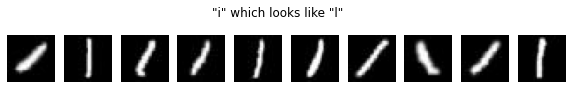

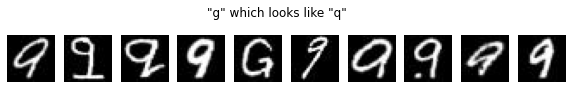

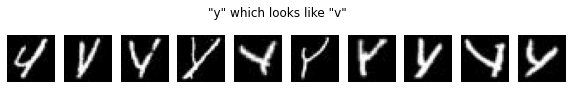

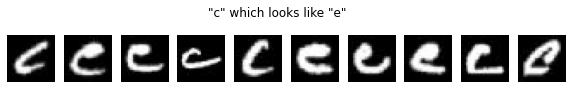

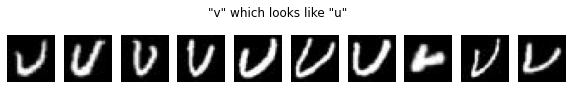

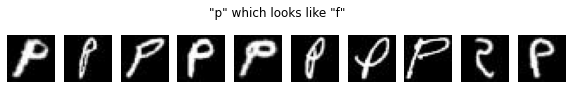

In [380]:
visualize_predicted_actual("i", "l", test_predictions, test_labels, test_data)
visualize_predicted_actual("g", "q", test_predictions, test_labels, test_data)
visualize_predicted_actual("y", "v", test_predictions, test_labels, test_data)
visualize_predicted_actual("c", "e", test_predictions, test_labels, test_data)
visualize_predicted_actual("v", "u", test_predictions, test_labels, test_data)
visualize_predicted_actual("p", "f", test_predictions, test_labels, test_data)

- There are just a couple of obvious reasons, why these letters get confused:
    - they originally look really similar
    - one letter can be upside-down version of another
    - people who wrote these letters had quite bad handwriting
    - goal of the dataset was to collect not the easiest cases, but also these ones

### How often does the initial letter of my surname get confused with other letters?

- Well, this letter is "B / b"
- At least, it's not in top 10

In [390]:
b_letter_occ = test_cf["b"].sort_values(ascending=False)
b_letter_occ = b_letter_occ[b_letter_occ > 0]

In [394]:
print("Letters, which get confused with `b`")

b_letter_occ

Mistakes


b    432
g      9
q      4
d      3
a      2
e      2
h      2
o      2
l      1
s      1
z      1
k      1
j      1
i      1
f      1
Name: b, dtype: int64

In [393]:
print("Number of occurences:", b_letter_occ.sum())

Number of occurences: 463


- Letter "b" is quite rarely confused with other letters
- Detection accuracy is 432 / 463 = ~93.3%

## Training CNN models

### [1x Conv2D] Choosing between ReLU and Tanh

In [147]:
# defining model architecture in a concise way
# best models are checkpointed

# NB! Here I decided not to use any validation sets and will try to get best model, validating directly on the test set
# (just for speed purposes)

# 1-layer cnn [conv1_size = 64, kernel_size=3]

# kernel_size value is ok here, i don't see any reasons to make it larger (e.g. 5)
# cause our image is kinda small itself,
# maybe i'll tune kernel_size and make it larger
# padding is ok too unless kernel_size <= 4

# tanh activation between layers

model_cnn1 = nn.Sequential(
    nn.Conv2d(1, 64, kernel_size=3, padding=1),
    nn.Tanh(),
    nn.AdaptiveAvgPool2d(14),
    nn.Flatten(),

    nn.Linear(64 * 14 * 14, 1024),
    nn.Tanh(),
    nn.LazyLinear(512),
    nn.Tanh(),
    nn.LazyLinear(26),
)

# training

# added label smoothing as it often really helps increasing metrics xd
loss = nn.CrossEntropyLoss(label_smoothing=0.1)
cnn1_loss, cnn1_train, cnn1_val, model = train_emnist(
    model_cnn1, 
    loss, 
    model_name="cnn1_tanh_conv1_64", 
    lr=3e-4, 
    batch_size=256, 
    num_epochs=10
)

# BEST TEST ACCURACY -- `0.924`

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

Epoch 0, Average loss: 1.546, Train accuracy: 0.685, Test accuracy: 0.817


  0%|          | 0/254 [00:00<?, ?it/s]

Epoch 1, Average loss: 1.105, Train accuracy: 0.843, Test accuracy: 0.869


  0%|          | 0/254 [00:00<?, ?it/s]

Epoch 2, Average loss: 1.060, Train accuracy: 0.857, Test accuracy: 0.876


  0%|          | 0/254 [00:00<?, ?it/s]

Epoch 3, Average loss: 0.944, Train accuracy: 0.897, Test accuracy: 0.903


  0%|          | 0/254 [00:00<?, ?it/s]

Epoch 4, Average loss: 0.945, Train accuracy: 0.897, Test accuracy: 0.904


  0%|          | 0/254 [00:00<?, ?it/s]

Epoch 5, Average loss: 0.882, Train accuracy: 0.918, Test accuracy: 0.912


  0%|          | 0/254 [00:00<?, ?it/s]

Epoch 6, Average loss: 0.896, Train accuracy: 0.914, Test accuracy: 0.906


  0%|          | 0/254 [00:00<?, ?it/s]

Epoch 7, Average loss: 0.844, Train accuracy: 0.931, Test accuracy: 0.918


  0%|          | 0/254 [00:00<?, ?it/s]

Epoch 8, Average loss: 0.861, Train accuracy: 0.926, Test accuracy: 0.912


  0%|          | 0/254 [00:00<?, ?it/s]

Epoch 9, Average loss: 0.819, Train accuracy: 0.941, Test accuracy: 0.924


In [148]:
# 1-layer cnn [conv1_size = 64, kernel_size=3]
# relu activation between layers

model_cnn1 = nn.Sequential(
    nn.Conv2d(1, 64, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(14),
    nn.Flatten(),

    nn.Linear(64 * 14 * 14, 1024),
    nn.ReLU(),
    nn.LazyLinear(512),
    nn.ReLU(),
    nn.LazyLinear(26),
)

# training
loss = nn.CrossEntropyLoss(label_smoothing=0.1)
cnn1_loss, cnn1_train, cnn1_val, model = train_emnist(
    model_cnn1, 
    loss, 
    model_name="cnn1_relu_conv1_64", 
    lr=3e-4, 
    batch_size=256, 
    num_epochs=10
)

# BEST TEST ACCURACY -- `0.935`

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

Epoch 0, Average loss: 1.624, Train accuracy: 0.660, Test accuracy: 0.817


  0%|          | 0/254 [00:00<?, ?it/s]

Epoch 1, Average loss: 1.076, Train accuracy: 0.857, Test accuracy: 0.880


  0%|          | 0/254 [00:00<?, ?it/s]

Epoch 2, Average loss: 1.006, Train accuracy: 0.879, Test accuracy: 0.902


  0%|          | 0/254 [00:00<?, ?it/s]

Epoch 3, Average loss: 0.909, Train accuracy: 0.912, Test accuracy: 0.917


  0%|          | 0/254 [00:00<?, ?it/s]

Epoch 4, Average loss: 0.909, Train accuracy: 0.911, Test accuracy: 0.917


  0%|          | 0/254 [00:00<?, ?it/s]

Epoch 5, Average loss: 0.854, Train accuracy: 0.929, Test accuracy: 0.929


  0%|          | 0/254 [00:00<?, ?it/s]

Epoch 6, Average loss: 0.864, Train accuracy: 0.925, Test accuracy: 0.928


  0%|          | 0/254 [00:00<?, ?it/s]

Epoch 7, Average loss: 0.824, Train accuracy: 0.939, Test accuracy: 0.932


  0%|          | 0/254 [00:00<?, ?it/s]

Epoch 8, Average loss: 0.834, Train accuracy: 0.935, Test accuracy: 0.925


  0%|          | 0/254 [00:00<?, ?it/s]

Epoch 9, Average loss: 0.800, Train accuracy: 0.947, Test accuracy: 0.935


In [150]:
# 1-layer cnn [conv1_size = 128, kernel_size=3]
# relu activation between layers
# Only conv1_size (128) differes it from the previous model (64), we won't use it later

model_cnn1 = nn.Sequential(
    nn.Conv2d(1, 128, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(14),
    nn.Flatten(),

    nn.Linear(128 * 14 * 14, 1024),
    nn.ReLU(),
    nn.LazyLinear(512),
    nn.ReLU(),
    nn.LazyLinear(26),
)

# training
loss = nn.CrossEntropyLoss(label_smoothing=0.1)
cnn1_loss, cnn1_train, cnn1_val, model = train_emnist(
    model_cnn1, 
    loss, 
    model_name="cnn1_relu_conv1_128",
    lr=3e-4, 
    batch_size=256, 
    num_epochs=10
)

# BEST TEST ACCURACY -- `0.936`
# it isn't really better than the previous one, so i'll stick to conv1_size == 64 in the first conv2d layer

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

Epoch 0, Average loss: 1.541, Train accuracy: 0.688, Test accuracy: 0.845


  0%|          | 0/254 [00:00<?, ?it/s]

Epoch 1, Average loss: 1.032, Train accuracy: 0.872, Test accuracy: 0.894


  0%|          | 0/254 [00:00<?, ?it/s]

Epoch 2, Average loss: 0.976, Train accuracy: 0.888, Test accuracy: 0.910


  0%|          | 0/254 [00:00<?, ?it/s]

Epoch 3, Average loss: 0.890, Train accuracy: 0.916, Test accuracy: 0.919


  0%|          | 0/254 [00:00<?, ?it/s]

Epoch 4, Average loss: 0.894, Train accuracy: 0.916, Test accuracy: 0.918


  0%|          | 0/254 [00:00<?, ?it/s]

Epoch 5, Average loss: 0.839, Train accuracy: 0.933, Test accuracy: 0.928


  0%|          | 0/254 [00:00<?, ?it/s]

Epoch 6, Average loss: 0.852, Train accuracy: 0.928, Test accuracy: 0.919


  0%|          | 0/254 [00:00<?, ?it/s]

Epoch 7, Average loss: 0.808, Train accuracy: 0.943, Test accuracy: 0.932


  0%|          | 0/254 [00:00<?, ?it/s]

Epoch 8, Average loss: 0.822, Train accuracy: 0.938, Test accuracy: 0.928


  0%|          | 0/254 [00:00<?, ?it/s]

Epoch 9, Average loss: 0.787, Train accuracy: 0.951, Test accuracy: 0.936


### [2x Conv2D] Testing 2-layer CNN

In [155]:
# 2-layer cnn [conv1_size = 64, conv2_size = 128, kernel_size=3]
# relu activation between layers

model_cnn2 = nn.Sequential(
    nn.Conv2d(1, 64, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(14),
    nn.Conv2d(64, 128, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(7),
    nn.Flatten(),

    nn.Linear(128 * 7 * 7, 1024),
    nn.ReLU(),
    nn.LazyLinear(512),
    nn.ReLU(),
    nn.LazyLinear(26),
)

# training
loss = nn.CrossEntropyLoss(label_smoothing=0.1)
cnn2_loss, cnn2_train, cnn2_val, model = train_emnist(
    model_cnn2, 
    loss, 
    model_name="cnn2_relu_conv1_64_conv2_128",
    lr=3e-4, 
    batch_size=256, 
    num_epochs=10
)

# BEST TEST ACCURACY -- `0.943`

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

Epoch 0, Average loss: 1.663, Train accuracy: 0.641, Test accuracy: 0.850


  0%|          | 0/254 [00:00<?, ?it/s]

Epoch 1, Average loss: 1.015, Train accuracy: 0.878, Test accuracy: 0.899


  0%|          | 0/254 [00:00<?, ?it/s]

Epoch 2, Average loss: 0.951, Train accuracy: 0.895, Test accuracy: 0.912


  0%|          | 0/254 [00:00<?, ?it/s]

Epoch 3, Average loss: 0.871, Train accuracy: 0.921, Test accuracy: 0.928


  0%|          | 0/254 [00:00<?, ?it/s]

Epoch 4, Average loss: 0.867, Train accuracy: 0.921, Test accuracy: 0.927


  0%|          | 0/254 [00:00<?, ?it/s]

Epoch 5, Average loss: 0.823, Train accuracy: 0.935, Test accuracy: 0.938


  0%|          | 0/254 [00:00<?, ?it/s]

Epoch 6, Average loss: 0.830, Train accuracy: 0.933, Test accuracy: 0.934


  0%|          | 0/254 [00:00<?, ?it/s]

Epoch 7, Average loss: 0.796, Train accuracy: 0.944, Test accuracy: 0.941


  0%|          | 0/254 [00:00<?, ?it/s]

Epoch 8, Average loss: 0.807, Train accuracy: 0.940, Test accuracy: 0.937


  0%|          | 0/254 [00:00<?, ?it/s]

Epoch 9, Average loss: 0.778, Train accuracy: 0.949, Test accuracy: 0.943


### [3x Conv2D] Testing 3-layer CNN

In [157]:
# 3-layer cnn [conv1_size = 64, conv2_size = 128, conv3_size=256, kernel_size=3]
# relu activation between layers

# configuration with 32/64/128 conv sizes was also tested, but has shown slightly worse results, so we'll use this version

model_cnn3 = nn.Sequential(
    nn.Conv2d(1, 64, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(14),
    nn.Conv2d(64, 128, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(7),
    nn.Conv2d(128, 256, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.Flatten(),

    nn.Linear(256 * 7 * 7, 1024),
    nn.ReLU(),
    nn.LazyLinear(512),
    nn.ReLU(),
    nn.LazyLinear(26),
)

# training
loss = nn.CrossEntropyLoss(label_smoothing=0.1)
cnn3_loss, cnn3_train, cnn3_val, model = train_emnist(
    model_cnn3, 
    loss, 
    model_name="cnn3_relu_conv1_64_conv2_128_conv3_256",
    lr=3e-4, 
    batch_size=256,
    num_epochs=10
)

# BEST TEST ACCURACY -- `0.943` (didn't change, but let's take this model for further experiments)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

Epoch 0, Average loss: 1.538, Train accuracy: 0.685, Test accuracy: 0.870


  0%|          | 0/254 [00:00<?, ?it/s]

Epoch 1, Average loss: 0.955, Train accuracy: 0.892, Test accuracy: 0.908


  0%|          | 0/254 [00:00<?, ?it/s]

Epoch 2, Average loss: 0.921, Train accuracy: 0.902, Test accuracy: 0.916


  0%|          | 0/254 [00:00<?, ?it/s]

Epoch 3, Average loss: 0.839, Train accuracy: 0.929, Test accuracy: 0.934


  0%|          | 0/254 [00:00<?, ?it/s]

Epoch 4, Average loss: 0.840, Train accuracy: 0.928, Test accuracy: 0.928


  0%|          | 0/254 [00:00<?, ?it/s]

Epoch 5, Average loss: 0.795, Train accuracy: 0.943, Test accuracy: 0.938


  0%|          | 0/254 [00:00<?, ?it/s]

Epoch 6, Average loss: 0.803, Train accuracy: 0.939, Test accuracy: 0.935


  0%|          | 0/254 [00:00<?, ?it/s]

Epoch 7, Average loss: 0.768, Train accuracy: 0.952, Test accuracy: 0.943


  0%|          | 0/254 [00:00<?, ?it/s]

Epoch 8, Average loss: 0.781, Train accuracy: 0.947, Test accuracy: 0.938


  0%|          | 0/254 [00:00<?, ?it/s]

Epoch 9, Average loss: 0.749, Train accuracy: 0.957, Test accuracy: 0.943


### Batch size correlation with BatchNorm

In [165]:
# 3-layer cnn [conv1_size = 64, conv2_size = 128, conv3_size=256, kernel_size=3]
# relu activation between layers
# batch norm
# batch size 64

model_cnn3 = nn.Sequential(
    nn.Conv2d(1, 64, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(14),
    nn.BatchNorm2d(64),
    nn.Conv2d(64, 128, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(7),
    nn.BatchNorm2d(128),
    nn.Conv2d(128, 256, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(256),
    nn.Flatten(),

    nn.Linear(256 * 7 * 7, 1024),
    nn.ReLU(),
    nn.LazyLinear(512),
    nn.ReLU(),
    nn.LazyLinear(26),
)

# training
loss = nn.CrossEntropyLoss(label_smoothing=0.1)
cnn3_loss, cnn3_train, cnn3_val, model = train_emnist(
    model_cnn3, 
    loss, 
    model_name="cnn3_relu_conv1_64_conv2_128_conv3_256_batchnorm_64",
    lr=3e-4, 
    batch_size=64,
    num_epochs=3
)

# BEST TEST ACCURACY -- `0.897` (3 epochs)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

Epoch 0, Average loss: 0.997, Train accuracy: 0.878, Test accuracy: 0.851


  0%|          | 0/1016 [00:00<?, ?it/s]

Epoch 1, Average loss: 0.796, Train accuracy: 0.941, Test accuracy: 0.897


  0%|          | 0/1016 [00:00<?, ?it/s]

Epoch 2, Average loss: 0.828, Train accuracy: 0.930, Test accuracy: 0.878


In [166]:
# 3-layer cnn [conv1_size = 64, conv2_size = 128, conv3_size=256, kernel_size=3]
# relu activation between layers
# batch norm
# batch size 512

model_cnn3 = nn.Sequential(
    nn.Conv2d(1, 64, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(14),
    nn.BatchNorm2d(64),
    nn.Conv2d(64, 128, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(7),
    nn.BatchNorm2d(128),
    nn.Conv2d(128, 256, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(256),
    nn.Flatten(),

    nn.Linear(256 * 7 * 7, 1024),
    nn.ReLU(),
    nn.BatchNorm1d(1024),
    nn.LazyLinear(512),
    nn.ReLU(),
    nn.BatchNorm1d(512),
    nn.LazyLinear(26),
)

# training
loss = nn.CrossEntropyLoss(label_smoothing=0.1)
cnn3_loss, cnn3_train, cnn3_val, model = train_emnist(
    model_cnn3, 
    loss, 
    model_name="cnn3_relu_conv1_64_conv2_128_conv3_256_batchnorm_512",
    lr=3e-4, 
    batch_size=512,
    num_epochs=3
)

# BEST TEST ACCURACY -- `0.087` (5 epochs)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

Epoch 0, Average loss: 1.006, Train accuracy: 0.875, Test accuracy: 0.072


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch 1, Average loss: 0.805, Train accuracy: 0.940, Test accuracy: 0.077


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch 2, Average loss: 0.804, Train accuracy: 0.940, Test accuracy: 0.087


**Conclusion**: Accuracy gets ridiculously small when big batch sizes are set (and models evidently overfit)

*I found some explanation/reference to the original GroupNorm paper, explaining this (and telling, why GroupNorm is better)*
*Source*: `https://amaarora.github.io/2020/08/09/groupnorm.html`

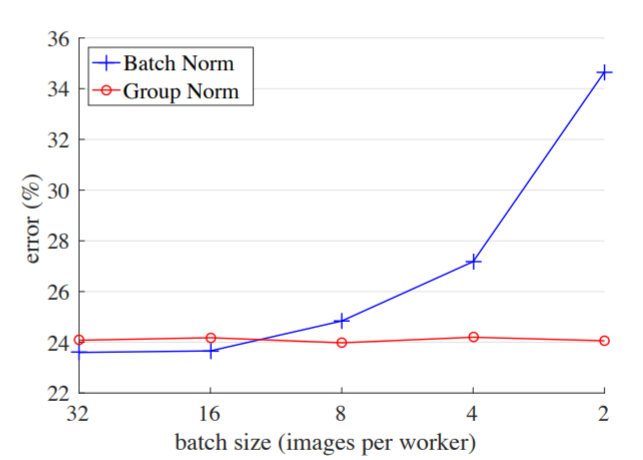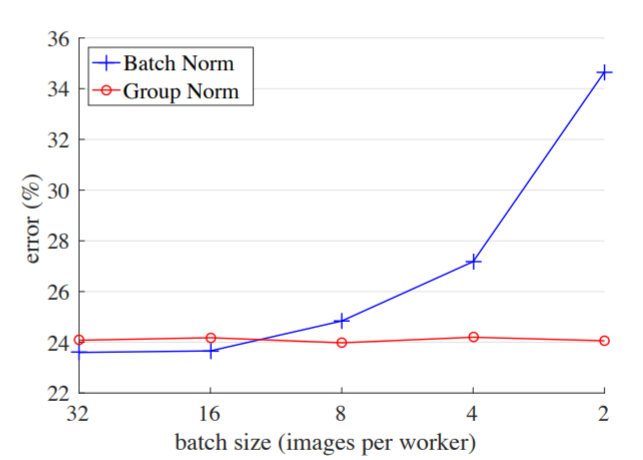

### Batch size correlation with GroupNorm

In [167]:
# 3-layer cnn [conv1_size = 64, conv2_size = 128, conv3_size=256, kernel_size=3]
# relu activation between layers
# group norm
# batch size 64

# this magic "32" is taken from the source above, it is the preferred number of groups, according to the GroupNorm paper authors
GROUP_NUM = 32

model_cnn3 = nn.Sequential(
    nn.Conv2d(1, 64, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(14),
    nn.GroupNorm(GROUP_NUM, 64),
    nn.Conv2d(64, 128, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(7),
    nn.GroupNorm(GROUP_NUM, 128),
    nn.Conv2d(128, 256, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.GroupNorm(GROUP_NUM, 256),
    nn.Flatten(),

    nn.Linear(256 * 7 * 7, 1024),
    nn.ReLU(),
    nn.LazyLinear(512),
    nn.ReLU(),
    nn.LazyLinear(26),
)

# training
loss = nn.CrossEntropyLoss(label_smoothing=0.1)
cnn3_loss, cnn3_train, cnn3_val, model = train_emnist(
    model_cnn3, 
    loss, 
    model_name="cnn3_relu_conv1_64_conv2_128_conv3_256_groupnorm_64",
    lr=3e-4, 
    batch_size=64,
    num_epochs=3
)

# BEST TEST ACCURACY -- `0.939` (3 epochs)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1016 [00:00<?, ?it/s]

Epoch 0, Average loss: 0.998, Train accuracy: 0.874, Test accuracy: 0.932


  0%|          | 0/1016 [00:00<?, ?it/s]

Epoch 1, Average loss: 0.792, Train accuracy: 0.941, Test accuracy: 0.940


  0%|          | 0/1016 [00:00<?, ?it/s]

Epoch 2, Average loss: 0.821, Train accuracy: 0.934, Test accuracy: 0.939


In [169]:
# 3-layer cnn [conv1_size = 64, conv2_size = 128, conv3_size=256, kernel_size=3]
# relu activation between layers
# group norm
# batch size 512

GROUP_NUM = 32

model_cnn3 = nn.Sequential(
    nn.Conv2d(1, 64, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(14),
    nn.GroupNorm(GROUP_NUM, 64),
    nn.Conv2d(64, 128, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(7),
    nn.GroupNorm(GROUP_NUM, 128),
    nn.Conv2d(128, 256, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.GroupNorm(GROUP_NUM, 256),
    nn.Flatten(),

    nn.Linear(256 * 7 * 7, 1024),
    nn.ReLU(),
    nn.LazyLinear(512),
    nn.ReLU(),
    nn.LazyLinear(26),
)

# training
loss = nn.CrossEntropyLoss(label_smoothing=0.1)
cnn3_loss, cnn3_train, cnn3_val, model = train_emnist(
    model_cnn3, 
    loss, 
    model_name="cnn3_relu_conv1_64_conv2_128_conv3_256_groupnorm_512",
    lr=3e-4, 
    batch_size=512,
    num_epochs=3
)

# BEST TEST ACCURACY -- `0.942` (3 epochs)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

Epoch 0, Average loss: 1.138, Train accuracy: 0.834, Test accuracy: 0.930


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch 1, Average loss: 0.815, Train accuracy: 0.937, Test accuracy: 0.942


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch 2, Average loss: 0.808, Train accuracy: 0.939, Test accuracy: 0.939


**Conclusion**: Comparing with BatchNorm, GroupNorm looks much more stable and powerful! 
- It's quality doesn't really depend on the batch size
- Moreover, it provides truly noticeable performance boost at the very beginning of the training, what I find fantastic ;D

### [3x Conv2D] Training 3-layer CNN for more epochs using GroupNorm

In [273]:
# 3-layer cnn [conv1_size = 64, conv2_size = 128, conv3_size=256, kernel_size=3]
# relu activation between layers
# lr -> 1e-4 
# group norm
# batch size 256

GROUP_NUM = 32

model_cnn3 = nn.Sequential(
    nn.Conv2d(1, 64, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(14),
    nn.GroupNorm(GROUP_NUM, 64),
    nn.Conv2d(64, 128, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(7),
    nn.GroupNorm(GROUP_NUM, 128),
    nn.Conv2d(128, 256, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.GroupNorm(GROUP_NUM, 256),
    nn.Flatten(),

    nn.Linear(256 * 7 * 7, 1024),
    nn.ReLU(),
    nn.LazyLinear(512),
    nn.ReLU(),
    nn.LazyLinear(26),
)

# training
loss = nn.CrossEntropyLoss(label_smoothing=0.1)
cnn3_loss, cnn3_train, cnn3_val, model = train_emnist(
    model_cnn3,
    loss, 
    model_name="cnn3_relu_conv1_64_conv2_128_conv3_256_groupnorm_256_final",
    lr=1e-4, 
    batch_size=256,
    num_epochs=10
)

# BEST TEST ACCURACY -- `0.952` (10 epochs)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

Epoch 0, Average loss: 1.097, Train accuracy: 0.850, Test accuracy: 0.934


  0%|          | 0/254 [00:00<?, ?it/s]

Epoch 1, Average loss: 0.813, Train accuracy: 0.939, Test accuracy: 0.942


  0%|          | 0/254 [00:00<?, ?it/s]

Epoch 2, Average loss: 0.808, Train accuracy: 0.939, Test accuracy: 0.940


  0%|          | 0/254 [00:00<?, ?it/s]

Epoch 3, Average loss: 0.756, Train accuracy: 0.955, Test accuracy: 0.947


  0%|          | 0/254 [00:00<?, ?it/s]

Epoch 4, Average loss: 0.763, Train accuracy: 0.953, Test accuracy: 0.943


  0%|          | 0/254 [00:00<?, ?it/s]

Epoch 5, Average loss: 0.727, Train accuracy: 0.965, Test accuracy: 0.949


  0%|          | 0/254 [00:00<?, ?it/s]

Epoch 6, Average loss: 0.736, Train accuracy: 0.962, Test accuracy: 0.945


  0%|          | 0/254 [00:00<?, ?it/s]

Epoch 7, Average loss: 0.710, Train accuracy: 0.970, Test accuracy: 0.952


  0%|          | 0/254 [00:00<?, ?it/s]

Epoch 8, Average loss: 0.719, Train accuracy: 0.967, Test accuracy: 0.950


  0%|          | 0/254 [00:00<?, ?it/s]

Epoch 9, Average loss: 0.698, Train accuracy: 0.974, Test accuracy: 0.952


#### BEST TEST SCORE –– 0.952 ... and that is >=0.95 ;)

## Pretrained model fine-tuning

In [9]:
wandb_logger = WandbLogger()
tensorboard_logger = TensorBoardLogger(save_dir="tb_runs/")

In [99]:
# function for loading data for pretrained torchvision models

def load_data(data_dir="./data"):
    train_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.RandomRotation(25),  # resize augmentation (10 degress) [only on train]
        transforms.Resize(28),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
    
    test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
    
    train_data = datasets.ImageFolder(root=f"{data_dir}/train", transform=train_transform)
    test_data = datasets.ImageFolder(root=f"{data_dir}/test", transform=test_transform)

    return train_data, test_data

In [105]:
resnet = models.resnet(pretrained=True)

for param in resnet.parameters():
    param.requires_grad = False
    net.fc = nn.Linear(512, 26)

In [1]:
loss = nn.CrossEntropyLoss(label_smoothing=0.1)

net_loss, net_train, net_val, model = train_emnist(
    resnet, 
    loss,
    optimizer_name="adam",
    model_name="resnet-emnist",
    lr=1e-2,
    batch_size=256,
    num_epochs=10
)

  0%|          | 0/254 [00:00<?, ?it/s]
Epoch 0, Average loss: 1.1394, Train accuracy: 0.6421, Test accuracy: 0.8972
  0%|          | 0/254 [00:00<?, ?it/s]
Epoch 1, Average loss: 0.4441, Train accuracy: 0.8253, Test accuracy: 0.8650
  0%|          | 0/254 [00:00<?, ?it/s]
Epoch 2, Average loss: 0.2746, Train accuracy: 0.9043, Test accuracy: 0.8772
  0%|          | 0/254 [00:00<?, ?it/s]
Epoch 3, Average loss: 0.2799, Train accuracy: 0.9134, Test accuracy: 0.8916
  0%|          | 0/254 [00:00<?, ?it/s]
Epoch 4, Average loss: 0.2114, Train accuracy: 0.9284, Test accuracy: 0.9175
  0%|          | 0/254 [00:00<?, ?it/s]
Epoch 5, Average loss: 0.2317, Train accuracy: 0.9249, Test accuracy: 0.9784
  0%|          | 0/254 [00:00<?, ?it/s]
Epoch 6, Average loss: 0.1847, Train accuracy: 0.9409, Test accuracy: 0.9765
  0%|          | 0/254 [00:00<?, ?it/s]
Epoch 7, Average loss: 0.1496, Train accuracy: 0.9496, Test accuracy: 0.9201
  0%|          | 0/254 [00:00<?, ?it/s]
Epoch 8, Average loss: 0

**Conclusion:**
- Well, it shows pretty decent accuracy, though it could be improved by making learning rate a bit lower and training it for a few more epochs

## Using Tensorboard

- I was logging everything I needed using Tensorboard so I can just send that info to the remote server

In [172]:
# logs are collected by SummaryWriter and stored in the `runs` folder
# we can look at them using 
# !tensorboard --logdir=runs

# Moreover, I can upload them to the remote hosting this way
# !tensorboard dev upload --logdir runs --name "Babii A.S. EMNIST Lab"